# Modelos Clasificadores de Tumor Benigno/Maligno o Ausencia de Tumor

### Carga, Transformación y Preprocesamiento de Datos

In [1]:
from processingData import process_data

train_loader, val_loader = process_data(path='../data/multiclassDataset')

### Creación del Primer Modelo (ResNet18)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
import torch_directml

# Seleccionamos los pesos pre-entrenados de la red
weights = ResNet18_Weights.DEFAULT

# Instanciamos el modelo con los pesos anteriores
model_base = resnet18(weights=weights)

# Congelamos todas las capas ocultas 
for param in model_base.parameters():
    param.requires_grad = False

# Reemplazar la capa fully-connected final 
num_ftrs = model_base.fc.in_features # numero de inputs de la capa final
model_base.fc = nn.Linear(num_ftrs, 3) # establecemos tres salidas (clasificación multiclase)

device = torch_directml.device() # Usamos la GPU de AMD 
model_base = model_base.to(device)

# Definición de la función de coste y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model_base.parameters()),
    lr=1e-2)

### Entrenamiento del Modelo

In [8]:
from training import train

train(model=model_base,
      train_loader=train_loader,
      criterion=criterion,
      optimizer=optimizer,
      num_epochs=5,
      device=device,
      task='multiclass')

Epoch 0 — Train Loss: 1.5017
Epoch 1 — Train Loss: 0.8911
Epoch 2 — Train Loss: 0.7929
Epoch 3 — Train Loss: 0.6635
Epoch 4 — Train Loss: 0.6911


In [9]:
# Guardamos este primer modelo
torch.save(model_base.state_dict(), "../models/multiclass_base.pth")

### Mejora del Modelo con Hyperparameter Tuning

In [10]:
model_tuned = resnet18(weights=weights) # misma arquitectura, con pesos default del modelo pre-entrenado

# Cambiamos la estructura de la última capa
num_ftrs = model_tuned.fc.in_features
model_tuned.fc = nn.Linear(num_ftrs, 3)

model_tuned = model_tuned.to(device)

# Redefinimios función de coste y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
            model_tuned.parameters(), # en este caso no congelamos capas ocultas, sino que refinamos los pesos de todas las capas
            lr=1e-4)

### Entrenamiento del Modelo Mejorado

In [11]:
train(model=model_tuned,
      train_loader=train_loader,
      criterion=criterion,
      optimizer=optimizer,
      num_epochs=5,
      device=device,
      task='multiclass')

Epoch 0 — Train Loss: 0.6864
Epoch 1 — Train Loss: 0.4281
Epoch 2 — Train Loss: 0.3196
Epoch 3 — Train Loss: 0.2059
Epoch 4 — Train Loss: 0.1636


In [12]:
# Guardamos el modelo tuned
torch.save(model_tuned.state_dict(), "../models/multiclass_tuned.pth")

### Evaluación de los Modelos

C:\Users\m7pan\AppData\Local\Temp\ipykernel_18072\186215536.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_base.load_state_dict(torch.load("../models/multiclass_b


---- MODELO BASE ----

Principales Métricas de Clasificación:

              precision    recall  f1-score   support

     Benigno       0.76      0.66      0.70        67
     Maligno       0.40      0.84      0.55        25
    Ausencia       0.71      0.20      0.31        25

    accuracy                           0.60       117
   macro avg       0.63      0.57      0.52       117
weighted avg       0.67      0.60      0.59       117



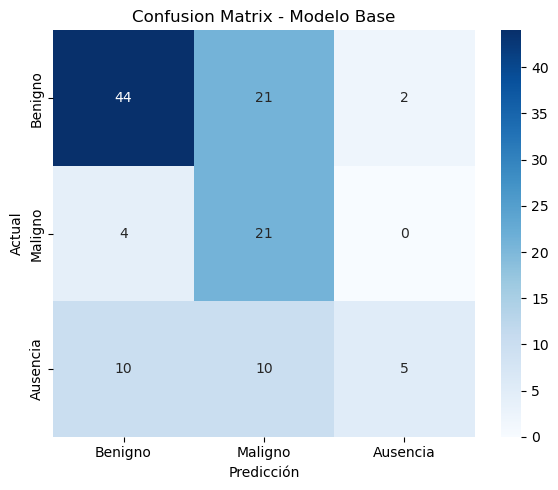


---- MODELO TUNED ----

Principales Métricas de Clasificación:

              precision    recall  f1-score   support

     Benigno       0.95      0.88      0.91        67
     Maligno       0.91      0.84      0.88        25
    Ausencia       0.75      0.96      0.84        25

    accuracy                           0.89       117
   macro avg       0.87      0.89      0.88       117
weighted avg       0.90      0.89      0.89       117



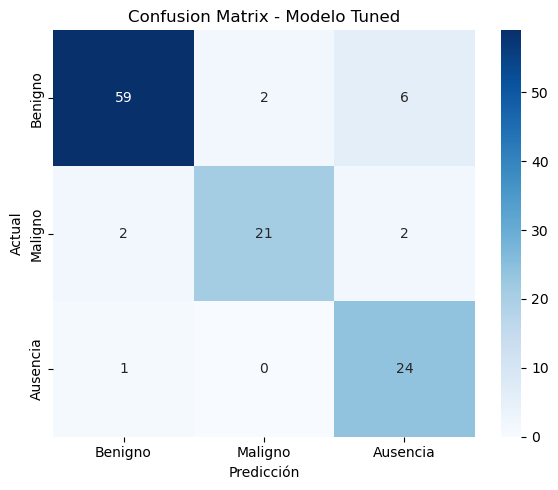

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from evaluating import get_metrics

# Primero cargamos los modelos
model_base = resnet18(weights=ResNet18_Weights.DEFAULT)
model_base.fc = nn.Linear(model_base.fc.in_features, 3)
model_base.load_state_dict(torch.load("../models/multiclass_base.pth"))
model_base.to(device)

model_tuned = resnet18(weights=ResNet18_Weights.DEFAULT)
model_tuned.fc = nn.Linear(model_tuned.fc.in_features, 3)
model_tuned.load_state_dict(torch.load("../models/multiclass_tuned.pth"))
model_tuned.to(device)

# Ahora evaluamos y obtenemos las principales métricas de cada uno
class_names = ['Benigno','Maligno','Ausencia']
creport_base, cm_base   = get_metrics(model_base, val_loader, device, task='multiclass', class_names=class_names)
creport_tuned, cm_tuned = get_metrics(model_tuned, val_loader, device, task='multiclass', class_names=class_names)

# Por últimos, las mostramos
print("\n---- MODELO BASE ----\n")
print("Principales Métricas de Clasificación:\n")
print(creport_base)

# Confusion Matrix del Modelo Base
plt.figure(figsize=(6, 5))
sns.heatmap(cm_base, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Modelo Base")
plt.tight_layout()
plt.show()

print("\n---- MODELO TUNED ----\n")
print("Principales Métricas de Clasificación:\n")
print(creport_tuned)

# Confusion Matrix del Modelo Tuned
plt.figure(figsize=(6, 5))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Modelo Tuned")
plt.tight_layout()
plt.show()